In [2]:
import os
import json
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

folder_path = "/home/simo/projects/datathon25/hackathon_data"
files_in_folder = os.listdir(folder_path)

len(files_in_folder)

def load_documents(json_file):
    """Loads the JSON file."""
    with open(json_file, 'r') as f:
      try:
          data = json.load(f)
          return data
      except json.JSONDecodeError:
          print(f"Error reading {json_file}, it may not be a valid JSON file.")
    return []

for filename in files_in_folder:
    if filename.endswith('.json'):
        file_path = os.path.join(folder_path, filename)
        page = load_documents(file_path)
        break
    
print(page.keys())
page

dict_keys(['url', 'timestamp', 'text_by_page_url', 'doc_id'])


{'url': 'http://usap.com',
 'timestamp': 1734945910.7553275,
 'text_by_page_url': {'http://usap.com': "U.S. Anesthesia Partners |\nSkip to main content\nSecondary Menu\nResearch\nNews\nNews Releases\nFTC Information\nContact\nPay My Bill\nMain navigation\nQuality care\nPatients\nPatient Information\nUnderstanding Anesthesia\nWorking With Your Care Team\nLabor & Delivery\nPediatrics\nBilling Information\nUnderstanding Fees & Billing\nGood Faith Estimates\nPatient Advocacy\nInsurance Accepted\nPay My Bill\nWho we work with\nSee Who We Work With\nPhysician groups\nFacility & system executives\nPayers & employers\nSurgeons\nCareers\nLocations\nOur Locations\nColorado\nFlorida\nIndiana\nMaryland\nNevada\nTennessee\nTexas (Central)\nTexas (Gulf Coast)\nTexas (North)\nTexas (South)\nWashington\nAbout\nAbout USAP\nWho we are\nThe USAP Difference\nLeadership\nUSAP Cares\nInvestments in Anesthesia\nSearch\nSubmit Search\nSearch\nQuality care\nPatients\nPatient Information\nUnderstanding Anesthes

In [3]:
num_subpages_per_page = []
char_counts_per_subpage = []

long_subpages = []   # Pages longer than 100k characters
samples_subpages = []  # Random sample of pages 0 < len <= 5000

LONG_TEXT_THRESHOLD = 100_000
RANDOM_SAMPLE_THRESHOLD = 5_000
MAX_SAVED = 100

random_subpage_candidates = []

for filename in tqdm(files_in_folder):
    if filename.endswith('.json'):
        file_path = os.path.join(folder_path, filename)
        page = load_documents(file_path)

        subpages = page.get('text_by_page_url', {}) # Get all the subpages in a dictionary of the form {url: text}

        num_subpages = len(subpages) # Number of subpages
        num_subpages_per_page.append(num_subpages)

        for subpage_url, text in subpages.items():
            
            length = len(text) # Length of subpage text
            char_counts_per_subpage.append(length)

            # Save long texts
            if length > LONG_TEXT_THRESHOLD and len(long_subpages) < MAX_SAVED:
                long_subpages.append({
                    "source_file": filename,
                    "page_url": subpage_url,
                    "char_length": length,
                    "text": text[:1000]
                })

            # Collect candidates for random sampling
            if length <= RANDOM_SAMPLE_THRESHOLD:
                random_subpage_candidates.append({
                    "source_file": filename,
                    "page_url": subpage_url,
                    "char_length": length,
                    "text": text[:1000]
                })

# Sample randomly from eligible candidates
samples_subpages = random.sample(random_subpage_candidates, min(len(random_subpage_candidates), MAX_SAVED))

# Output paths
base_output_path = os.path.abspath(os.path.join(folder_path, ".."))
long_subpages_output_path = os.path.join(base_output_path, "subpages_over_100k.json")
short_subpages_output_path = os.path.join(base_output_path, "subpages_empty.json")
random_subpages_output_path = os.path.join(base_output_path, "random_subpages_under_5k.json")

# Save long subpages
with open(long_subpages_output_path, "w", encoding="utf-8") as f:
    json.dump(long_subpages, f, ensure_ascii=False, indent=2)

# Save random subpages
with open(random_subpages_output_path, "w", encoding="utf-8") as f:
    json.dump(samples_subpages, f, ensure_ascii=False, indent=2)

# Final output
print("Summary Statistics:")
print(f"Mean number of subpages per page: {np.array(num_subpages_per_page).mean()}")
print(f"Total number of text blocks processed: {len(char_counts_per_subpage)}")
print(f"Example character counts per text block: {char_counts_per_subpage[:10]}")
print(f"Saved {len(long_subpages)} long subpages blocks to: {long_subpages_output_path}")
print(f"Saved {len(samples_subpages)} random subpage blocks (0 < len <= 5k) to: {random_subpages_output_path}")


100%|██████████| 13144/13144 [01:40<00:00, 130.95it/s]

Summary Statistics:
Mean number of subpages per page: 58.46606816798539
Total number of text blocks processed: 768478
Example character counts per text block: [4086, 3405, 14970, 8222, 2330, 2676, 4086, 8318, 3540, 2827]
Saved 100 long subpages blocks to: /home/simo/projects/datathon25/subpages_over_100k.json
Saved 100 random subpage blocks (0 < len <= 5k) to: /home/simo/projects/datathon25/random_subpages_under_5k.json


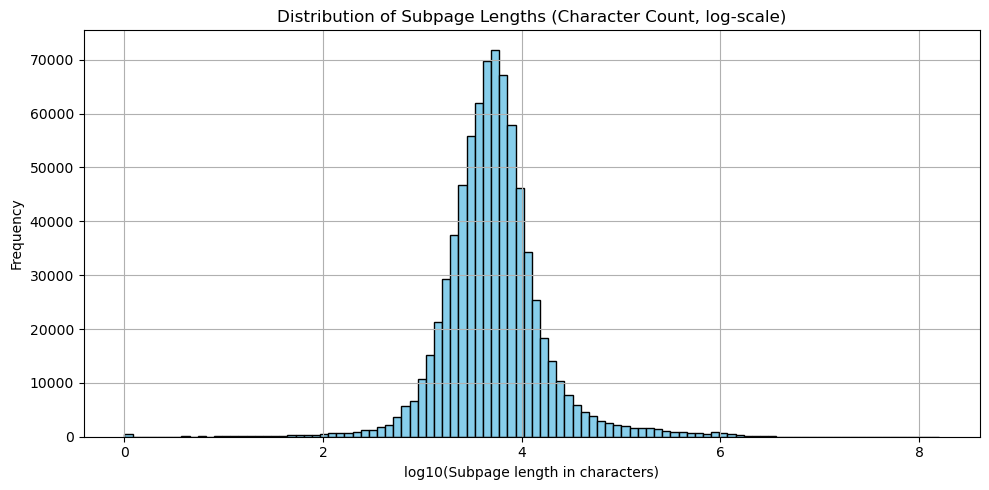

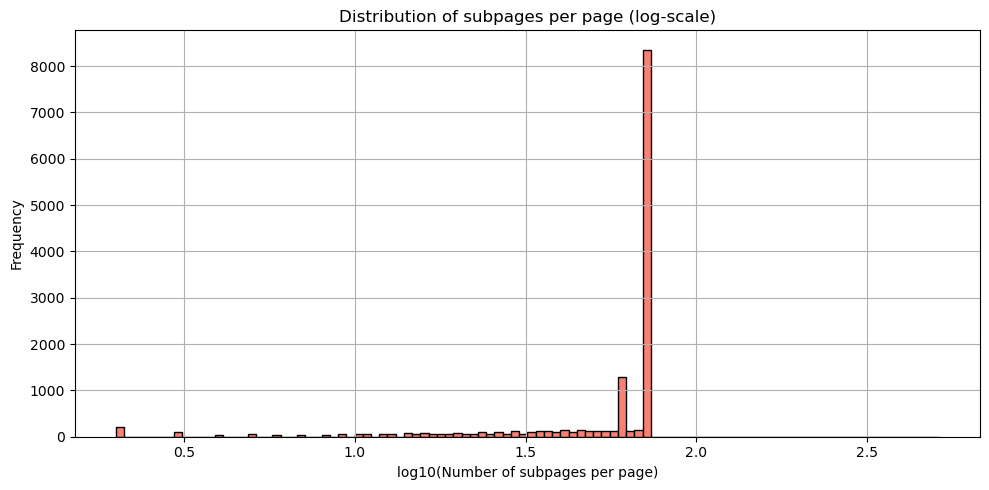

Mean character count: 18316.37016804645
Mean number of subpages per page: 58.46606816798539


In [20]:
char_counts_per_subpage_np = np.array(char_counts_per_subpage)
log_lengths = np.log10(char_counts_per_subpage_np + 1)

plt.figure(figsize=(10, 5))
plt.hist(log_lengths, bins=100, color='skyblue', edgecolor='black')
plt.xlabel("log10(Subpage length in characters)")
plt.ylabel("Frequency")
plt.title("Distribution of Subpage Lengths (Character Count, log-scale)")
plt.grid(True)
plt.tight_layout()
# Download the picture of the histogram
plt.savefig(os.path.join(base_output_path, "subpage_length_distribution.png"))
plt.show()

items_array = np.array(num_subpages_per_page)
log_items = np.log10(items_array + 1)

plt.figure(figsize=(10, 5))
plt.hist(log_items, bins=100, color='salmon', edgecolor='black')
plt.xlabel("log10(Number of subpages per page)")
plt.ylabel("Frequency")
plt.title("Distribution of subpages per page (log-scale)")
plt.grid(True)
plt.tight_layout()
# Download the picture of the histogram
plt.savefig(os.path.join(base_output_path, "subpages_per_page_distribution.png"))
plt.show()

print("Mean character count:", np.mean(char_counts_per_subpage_np))
print("Mean number of subpages per page:", np.mean(num_subpages_per_page))

In [10]:
num_subpages_per_page_filtered = []
char_counts_per_subpage_filtered = []


for filename in tqdm(files_in_folder):
    if filename.endswith('.json'):
        file_path = os.path.join(folder_path, filename)
        page = load_documents(file_path)

        subpages = page.get('text_by_page_url', {}) # Get all the subpages in a dictionary of the form {url: text}

        num_subpages = len(subpages) # Number of subpages
        num_subpages_per_page_filtered.append(num_subpages)

        for subpage_url, text in subpages.items():

            if 'css' in subpage_url or 'json' in subpage_url:
                continue
            
            length = len(text) # Length of subpage text
            char_counts_per_subpage_filtered.append(length)


# Final output
print("Summary Statistics:")
print(f"Mean number of subpages per page: {np.array(num_subpages_per_page).mean()}")
print(f"Total number of text blocks processed: {len(char_counts_per_subpage)}")

100%|██████████| 13144/13144 [01:37<00:00, 134.28it/s]

Summary Statistics:
Mean number of subpages per page: 58.46606816798539
Total number of text blocks processed: 768478


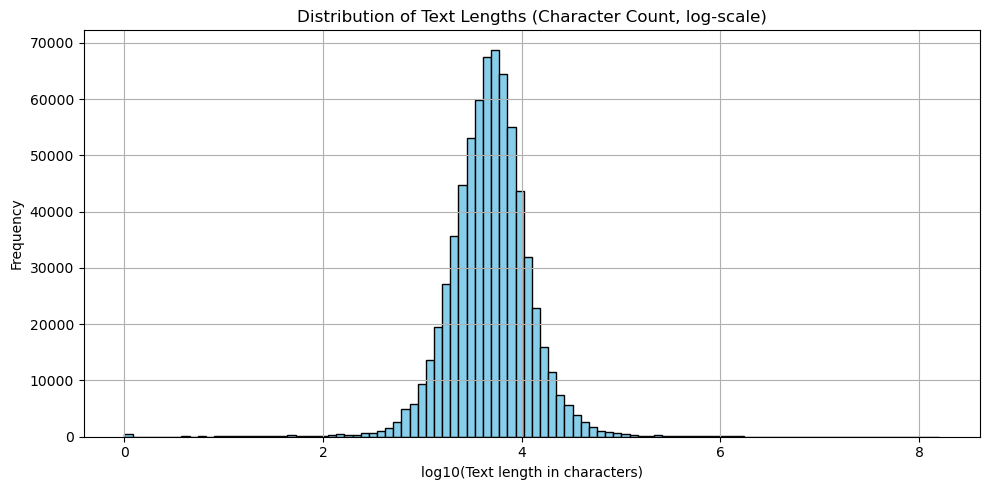

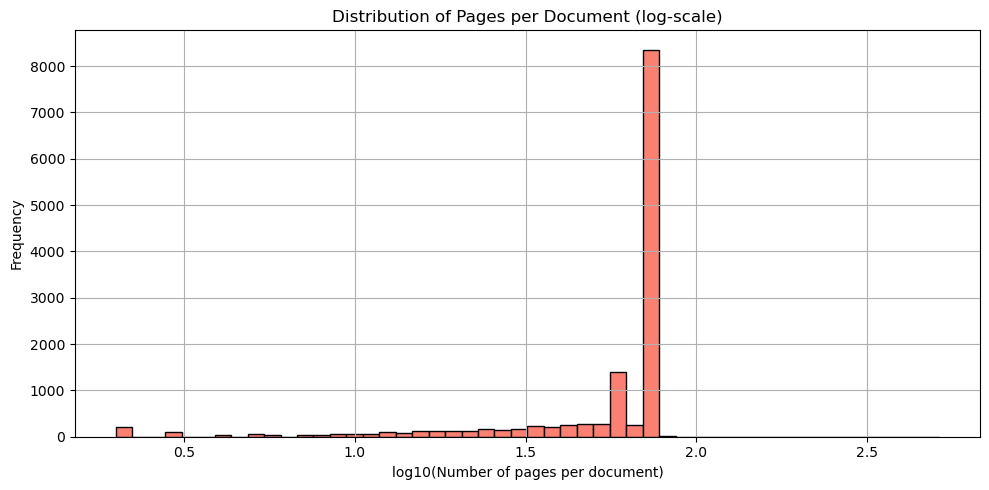

Mean character count: 10369.978581647723


In [19]:
import matplotlib.pyplot as plt
import numpy as np

char_counts_per_subpage_filtered_np = np.array(char_counts_per_subpage_filtered)
log_lengths_filtered = np.log10(char_counts_per_subpage_filtered_np + 1)

plt.figure(figsize=(10, 5))
plt.hist(log_lengths_filtered, bins=100, color='skyblue', edgecolor='black')
plt.xlabel("log10(Text length in characters)")
plt.ylabel("Frequency")
plt.title("Distribution of Text Lengths (Character Count, log-scale)")
plt.grid(True)
plt.tight_layout()
# Download the picture of the histogram
plt.savefig(os.path.join(base_output_path, "text_length_distribution_filtered.png"))
plt.show()

items_array_filtered = np.array(num_subpages_per_page_filtered)
log_items = np.log10(items_array_filtered + 1)

plt.figure(figsize=(10, 5))
plt.hist(log_items, bins=50, color='salmon', edgecolor='black')
plt.xlabel("log10(Number of pages per document)")
plt.ylabel("Frequency")
plt.title("Distribution of Pages per Document (log-scale)")
plt.grid(True)
plt.tight_layout()
# Download the picture of the histogram
plt.savefig(os.path.join(base_output_path, "pages_per_document_distribution_filtered.png"))
plt.show()

print("Mean character count:", np.mean(char_counts_per_subpage_filtered_np))